In [3]:
from model import BioCNN, MultiStreamBioCNN
import torch
from thop import profile
import pandas as pd

In [4]:
# instance models
model_bio = BioCNN()
model_ecg_ppg = BioCNN(in_channels=2)
model_multibio = MultiStreamBioCNN()

In [5]:
# random input for convolutional layers
random_input_bio = torch.rand(1, 1, 32, 32)
random_input_multibio = torch.rand(1, 2, 32, 32)

# random input for fully conected layers
random_input_bio2 = torch.rand(1, 128)
random_input_multibio2 = torch.rand(1, 256)

In [6]:
# calculate number flops and number total paramaters 
flops_bio, params_bio = profile(
    model_bio, inputs=(random_input_bio,))

flops_ecg_ppg, params_ecg_ppg = profile(
    model_ecg_ppg, inputs=(random_input_multibio,))

flops_multibio, params_multibio = profile(
    model_multibio, inputs=(random_input_multibio,))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch

In [7]:
# calculate number flops and number send paramaters 
_, param_bio_send = profile(
    model_bio.fc, inputs=(random_input_bio2,))

_, param_ecg_ppg_send = profile(
    model_ecg_ppg.fc, inputs=(random_input_bio2,))

_, param_multibio_send = profile(
    model_multibio.fc, inputs=(random_input_multibio2,))

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [8]:
data = {
    'ECG': [flops_bio, params_bio],
    'PPG': [flops_bio, params_bio],
    'ECG_PPG': [flops_ecg_ppg, params_ecg_ppg],
    'Fusion': [flops_multibio, params_multibio],
    'ECG (Slipt)': [flops_bio, param_bio_send],
    'PPG (Slipt)': [flops_bio, param_bio_send],
    'ECG_PPG (Slipt)': [flops_ecg_ppg, param_ecg_ppg_send],
    'Fusion (Slipt)': [flops_multibio, param_multibio_send]
}

In [9]:
df = pd.DataFrame.from_dict(data, orient="index", columns=["FLOPs", "Send Parameters"])

# Convertendo para KB
df['Send Size (KB)'] = df['Send Parameters'] / 2**10
df.drop('Send Parameters', axis=1, inplace=True)

# Convertendo para mega FLOPS
df['Mega FLOPs'] = df['FLOPs']/1e6
df.drop('FLOPs', axis=1, inplace=True)

In [23]:
df.to_csv('flops and size.csv')
display(df)

,Send Size (KB),Mega FLOPs
ECG,187.473633,1.409536
PPG,187.473633,1.409536
ECG_PPG,187.543945,1.483264
Fusion,347.895508,2.791936
ECG (Slipt),91.051758,1.409536
PPG (Slipt),91.051758,1.409536
ECG_PPG (Slipt),91.051758,1.483264
Fusion (Slipt),155.051758,2.791936


In [61]:
send_ecg = df[['Send Size (KB)']].loc['ECG'].values[0]
send_ppg = df[['Send Size (KB)']].loc['PPG'].values[0]
send_ecg_ppg = df[['Send Size (KB)']].loc['ECG_PPG'].values[0]
send_fusion = df[['Send Size (KB)']].loc['Fusion (Slipt)'].values[0]

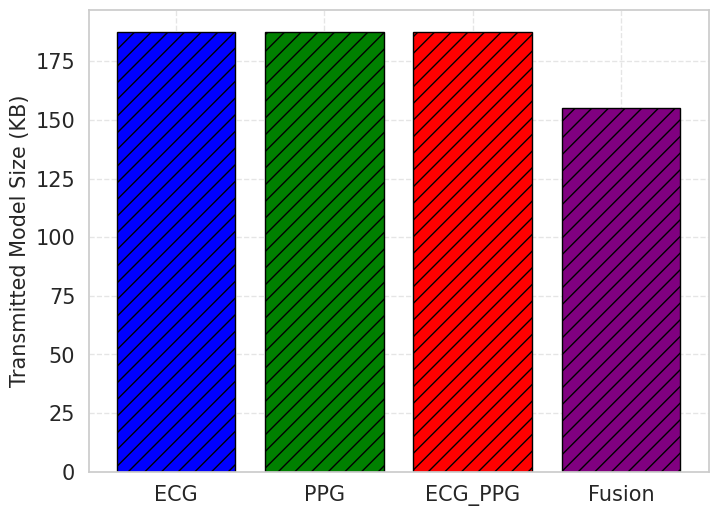

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados para o gráfico
labels = ['ECG', 'PPG', 'ECG_PPG', 'Fusion']
send_sizes = [send_ecg, send_ppg, send_ecg_ppg, send_fusion]  # Calculando a média

# Estilizando o gráfico com seaborn
sns.set(style="whitegrid")  # Estilo de fundo branco com grid

# Criando o gráfico de barras
plt.figure(figsize=(8,6))

# Adicionando diferentes estilos para cada barra
bars = plt.bar(labels, send_sizes, color=['blue', 'green', 'red', 'purple'], edgecolor='black', linewidth=2)

# Estilizando cada barra individualmente
for i, bar in enumerate(bars):
    bar.set_linewidth(1)  # Largura da borda
    bar.set_hatch('//')  # Padrão de hachura para todas as barras

# Adicionando título e rótulos
plt.ylabel('Transmitted Model Size (KB)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Exibindo o gráfico
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('send size.pdf', bbox_inches='tight')
plt.show()
